# Test peakdet code for Power replication

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import json
import numpy as np

from peakdet import load_physio, operations, analytics

In [2]:
physio_file = "/Users/taylor/Desktop/sub-03_task-cuedSGT_run-01_physio.tsv.gz"
physio_json = "/Users/taylor/Desktop/sub-03_task-cuedSGT_run-01_physio.json"

with open(physio_json, "r") as fo:
    physio_metadata = json.load(fo)

sampling_rate = physio_metadata["SamplingFrequency"]
resp_idx = physio_metadata["Columns"].index("respiratory")
card_idx = physio_metadata["Columns"].index("cardiac")
physio_data = np.loadtxt(physio_file)
resp_data = physio_data[:, resp_idx]
card_data = physio_data[:, card_idx]

# Mean-center data prior to feeding it to peakdet
resp_data = resp_data - np.mean(resp_data)
#card_data = card_data - np.mean(card_data)

card_physio = load_physio(card_data, fs=sampling_rate)
resp_physio = load_physio(resp_data, fs=sampling_rate)

TARGET_SAMPLING_RATE = 250
card_physio_upsampled = operations.interpolate_physio(
    card_physio,
    target_fs=TARGET_SAMPLING_RATE,
)

/Users/taylor/Documents/tsalo/peakdet/peakdet/io.py:67: UserWarning: Loading data from a numpy array without providing ahistory will render reproducibility functions useless! Continuing anyways.
  warnings.warn('Loading data from a numpy array without providing a'


In [3]:
# Temporal filtering
resp_physio = operations.filter_physio(resp_physio, cutoffs=1.0, method="lowpass")
card_physio = operations.filter_physio(card_physio, cutoffs=3.0, method="lowpass")
card_physio_upsampled = operations.filter_physio(card_physio_upsampled, cutoffs=3.0, method="lowpass")

In [4]:
# Peak/trough detection
resp_physio = operations.peakfind_physio(resp_physio, thresh=0.2, dist=None)
card_physio = operations.peakfind_physio(card_physio, thresh=0.1, dist=None)
card_physio_upsampled = operations.peakfind_physio(card_physio_upsampled, thresh=0.1, dist=None)

In [5]:
n_seconds_in_scan = card_physio.data.size / sampling_rate
n_upsampled_points = int(n_seconds_in_scan * TARGET_SAMPLING_RATE)
n_points = int(n_seconds_in_scan * sampling_rate)

time_upsampled = np.linspace(0, n_seconds_in_scan, n_upsampled_points)
time_regular = np.linspace(0, n_seconds_in_scan, n_points)

<ipython-input-6-18cc9183cb70>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


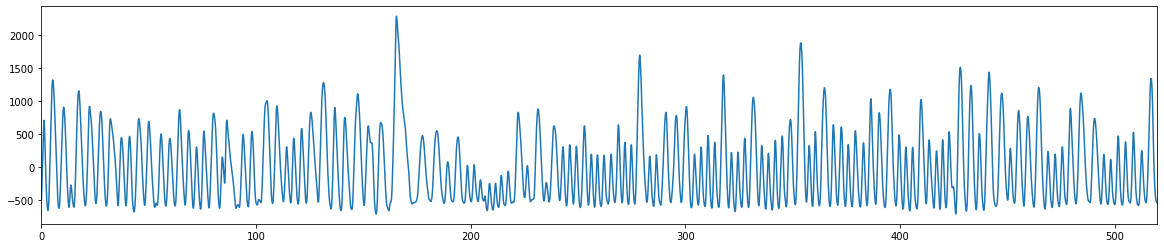

In [6]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(time_regular, resp_physio.data)
ax.set_xlim(0, n_seconds_in_scan)
fig.show()

<ipython-input-7-347f3ec961e8>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


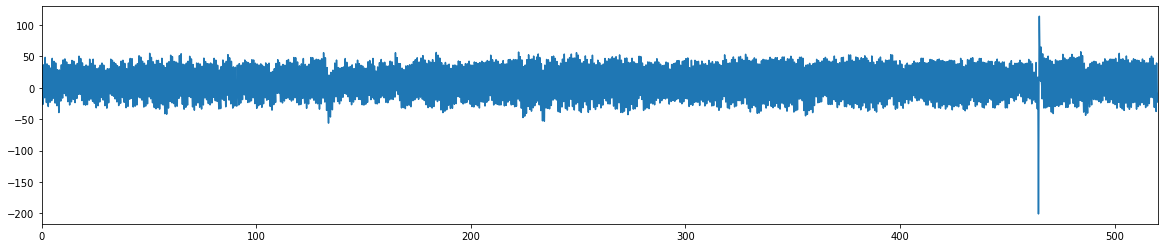

In [7]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(time_regular, card_physio.data)
ax.set_xlim(0, n_seconds_in_scan)
fig.show()
# weird spike is around 460s

<ipython-input-15-edd73b36877f>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


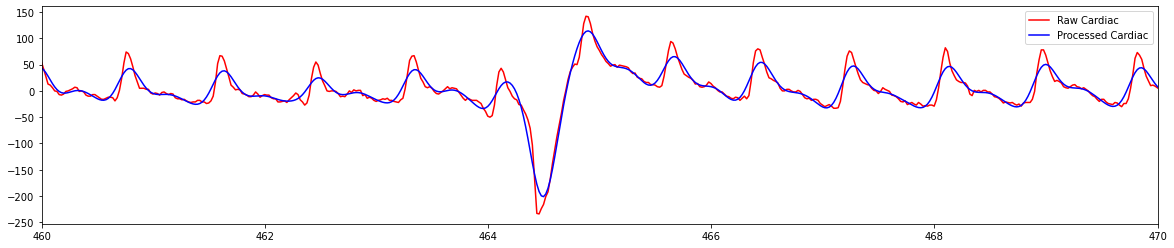

In [15]:
# print the raw data around the weird spike
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(time_regular, card_data, label="Raw Cardiac", color="red")
ax.plot(time_regular, card_physio.data, label="Processed Cardiac", color="blue")
ax.set_xlim(start_sec, start_sec + n_sec)

ax.legend()

fig.show()
# weird spike is around 460s

In [8]:
#std = np.std(card_physio.data)
#threshold = std * 3
#print(threshold)
#bad_peaks = card_physio.peaks[card_physio.data[card_physio.peaks] > threshold]
#bad_troughs = card_physio.troughs[card_physio.data[card_physio.troughs] < -threshold]

# card_physio = operations.delete_peaks(card_physio, bad_peaks)

<ipython-input-9-2bcca08e5106>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


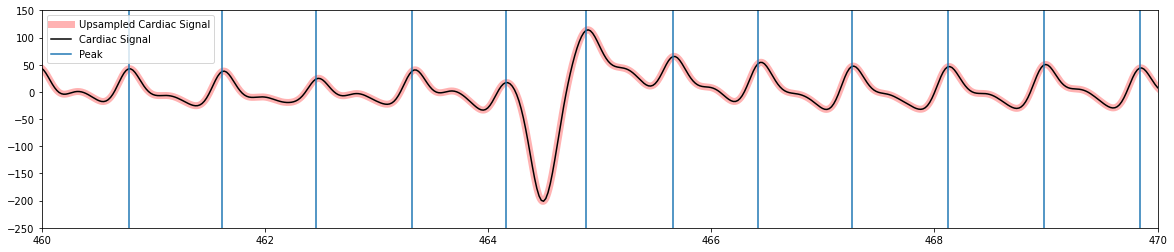

In [9]:
fig, ax = plt.subplots(figsize=(20, 4))

start_sec = 460
n_sec = 10

ax.plot(
    time_upsampled, 
    card_physio_upsampled.data,
    color="red",
    label="Upsampled Cardiac Signal",
    linewidth=7,
    alpha=0.3,
)
ax.plot(
    time_regular, 
    card_physio,
    color="black",
    label="Cardiac Signal",
)

for peak in card_physio.peaks:
    ax.axvline(peak / sampling_rate, label="Peak")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlim(start_sec, start_sec + n_sec)
ax.set_ylim(-250, 150)
fig.show()

In [10]:
# Calculate IHR
instantaneous_heart_rate = np.empty(card_physio.data.shape)

for i_peak in range(len(card_physio.peaks) - 1):
    peak1 = card_physio.peaks[i_peak]
    peak2 = card_physio.peaks[i_peak + 1]
    temp_hr = (peak2 - peak1) / sampling_rate  # bps
    temp_hr = 60 / temp_hr  # convert to bpm
    instantaneous_heart_rate[peak1:peak2] = temp_hr
    if i_peak == 0:
        instantaneous_heart_rate[:peak1] = temp_hr

    if i_peak == len(card_physio.peaks) - 2:
        instantaneous_heart_rate[peak2:] = temp_hr


<ipython-input-11-609b2eee65e6>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


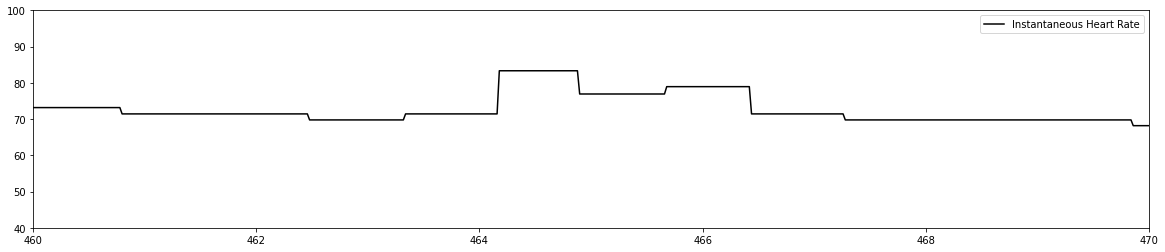

In [11]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(
    np.linspace(0, n_seconds_in_scan, n_points), 
    instantaneous_heart_rate, 
    label="Instantaneous Heart Rate", 
    color="black",
)

bad_timepoints = np.where(np.abs(np.diff(instantaneous_heart_rate)) > 25)[0]
for bad_tp in bad_timepoints:
    ax.axvline(
        bad_tp / sampling_rate, 
        alpha=0.3,
        color="red", 
        label="Bad Timepoint",
    )

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

#ax.set_xlim(0, n_seconds_in_scan)
ax.set_xlim(start_sec, start_sec + n_sec)
ax.set_ylim(40, 100)
fig.show()